La phase précédente de web scraping des données nous a permis de récupérer des données provenant de différentes sources internet et des les enregistrer sous la forme d'un data frame Pandas.

# Préparation du data frame

**Dans cette partie, nous allons tenter de mieux comprendre nos données et de les préparer pour la partie suivante à savoir la phase d'apprentissage et de prédiction.**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8,8)

In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif

In [3]:
from script import convert_float, drop_inutile, select_features_kbest, data_frame_final, robuste_std, melange,multiplot2,  multiplot, outliers, graph_corr
import script as sc

In [4]:
df = pd.read_csv("df.csv")

La phase de webscraping nous a permis d'extraire **18 variables** :
* *pop_2013* : la population en 2014
* *pop_2017* : la population en 2017
* *pop_2018* : la population en 2018
* *superficie* : la superficie en km^2
* *densite* : la densité de population en km^2
* *nb_commune* : le nombre de communes
* *pop_municipale* : la population municipale
* *hab_m* : le nombre d'habitants moyen par commune
* *pib_2015* : le pib en 2015
* *pib_2005* : le pib en 2005
* *pib_2000* : le pib en 2000
* *décla* : la moyenne mensualisée des montants déclarés aux impôts
* *taxe_om* : le taux de taxe communale sur les ordures ménagères
* *impot* : le montant moyen d'impôt sur le revenu
* *nom* : le nom du département
* *code* : le code du département
* *r_moyen* : le revenu moyen annuel

On peut observer succintement un extrait du jeu de données. 

In [5]:
display(df.head())

,code_x,nom,pop_2013,pop_2017,pop_2018,superficie,densite,pib_2015,pib_2005,pib_2000,code_y,nb_commune,pop_municipale,hab_m,rmoyen,décla,taxe_om,impot
0,59,N o r d,2595536,2604361,2606234,5743,454,NaN,23567,19794,59,650,2579208,3968,2427,24887,"18,07",3414
1,75,P a r i s,2229621,2187526,2175601,105,20641,96400.0,75439,67502,75,1,2249975,2249975,4007,48301,"13,50",11750
2,13,B o u c h e s - d u - R h ô n e,1993177,2024162,2034357,5087,400,34200.0,27818,23521,13,119,1975896,16604,2570,26751,"21,06",3996
3,93,S e i n e - S a i n t - D e n i s,1552482,1623111,1632677,236,6912,38900.0,27420,23305,93,40,1529928,38248,2398,21768,"21,91",3095
4,92,H a u t s - d e - S e i n e,1591403,1609306,1619120,176,9221,97500.0,73277,62244,92,36,1581628,43934,3885,45966,"16,04",9162


## Preprocessing

* On convertit certaines variables en **float** (*superficie, densite, taxe_om*)

* On se débarrasse de la variables *pib_2015* qui compte trop de NAs et d'autres **variables inutiles** comme le code du département car nous n'en avons pas besoin. 

* On **transforme nos données** selon RobustScaler (choisi car nous avons des valeurs extrêmes) :  Il transforme les données de la manière suivante :$$X_{scaled}=\frac{X-mediane}{IQR}$$ avec $IQR$ l'écart entre le premier et le troisième quartile. 

* On **mélange** notre jeu de données car il est présentement classé par ordre décroissant de population, ce qui peut nous causer des problèmes ultérieurement.
    
* On se débarrasse de la donnée sur Paris car c'est un **point trop extrême** qui va poser problème plus tard. 

On utilise un système de **pipeline** afin de réaliser toutes ces transformations de manière successive.

In [6]:
new_df=(
    df
    .pipe(sc.convert_float)
    .pipe(sc.drop_inutile)
    .pipe(sc.robuste_std)
    .pipe(sc.melange)
    .pipe(sc.outliers)
)

## Observation des données 

Le data frame est totalement exploitable dès à présent. On peut commencer par **observer rapidement nos données sous la forme de nuages de points**. Les variables sont représentées par rapport au revenu moyen annuel.

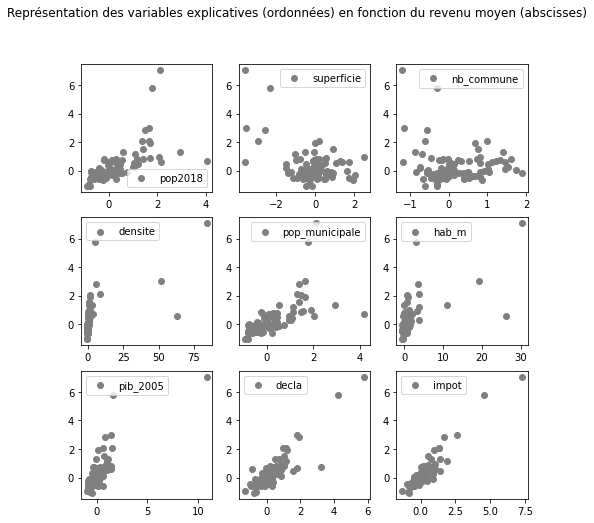

In [7]:
multiplot(new_df)

In [8]:
new_df.describe()

,pop_2013,pop_2017,pop_2018,superficie,densite,pib_2005,pib_2000,nb_commune,pop_municipale,hab_m,rmoyen,décla,taxe_om,impot
count,9.100000e+01,9.100000e+01,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000
mean,6.350553e+05,6.452118e+05,0.214507,-0.099962,2.550764,0.226524,0.177558,0.167775,0.190900,1.284256,0.329189,0.248531,0.107259,0.185033
std,4.643935e+05,4.763768e+05,0.934377,1.110667,12.140406,1.290995,1.287642,0.699348,0.938216,4.772993,1.200068,1.037207,0.731293,1.136730
min,7.660700e+04,7.660100e+04,-0.898114,-3.597758,-0.606897,-0.941214,-1.115319,-1.198421,-0.938821,-0.567582,-1.085339,-1.301887,-1.318885,-1.315115
25%,3.070405e+05,3.058505e+05,-0.452383,-0.471980,-0.298851,-0.388135,-0.410947,-0.309970,-0.470774,-0.265013,-0.332604,-0.362760,-0.477812,-0.479362
50%,5.333200e+05,5.344900e+05,-0.007929,0.001245,-0.018391,-0.000861,-0.002768,0.001974,-0.012502,-0.008503,-0.008753,-0.006473,0.002064,-0.004555
75%,7.849340e+05,8.104265e+05,0.543520,0.516189,0.703448,0.600991,0.500786,0.689042,0.484729,0.701860,0.654267,0.593582,0.547988,0.514091
max,2.595536e+06,2.604361e+06,4.031685,2.504359,84.045977,10.859388,10.640075,1.881540,4.189435,30.289460,7.072210,5.786118,2.505676,7.255337


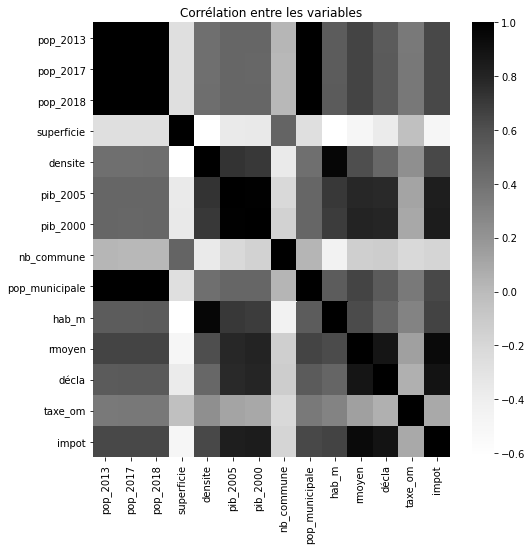

In [9]:
graph_corr(new_df)

Ce graphique nous permet aussi d'observer que **les variables issues d'une même source sont souvent très corrélées**.

## Sélection des variables

Nous allons maintenant **sélectionner les variables que l'on va garder pour la phase d'apprentissage**. 

* Utilisation de la fonction SelectKBest,
* Critère du f_score,
* Objectif de sept variables. 

On peut observer **l'importance des variables** dans le graphique suivant.

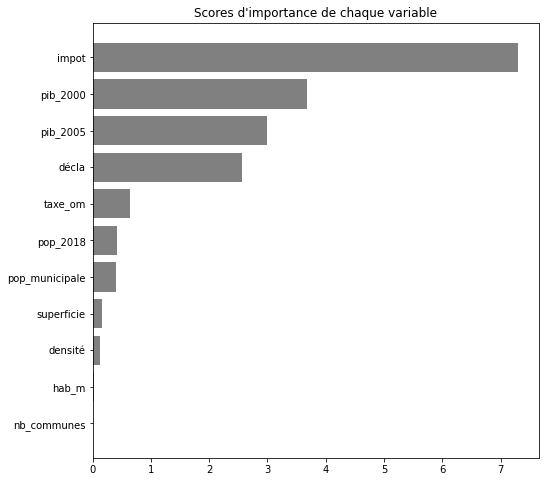

In [10]:
scores, selected = select_features_kbest(new_df)

## Constitution du data frame final

*Le message d'erreur suivant apparait à cause de la technique que nous utilisons pour récupérer les index des colonnes choisies. Cela ne nuit pas à la procédure.*

In [11]:
df_final = data_frame_final(selected, new_df)

/home/melissaznf/python M2/script.py:577: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['revenu_moyen']=v
/home/melissaznf/python M2/script.py:578: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['departement']=w


Les **variables sélectionnées** sont :

* *pop_2018*
* *pop_municipale*
* *pib_2005*
* *pib_2000*
* *décla*
* *taxe_om*
* *impot*

et bien évidemment *revenu_moyen*.

In [12]:
df_final

,pop_2018,pop_municipale,pib_2005,pib_2000,décla,taxe_om,impot,revenu_moyen
departement,,,,,,,,
S e i n e - M a r i t i m e,1.400178,1.467691,0.804694,0.813841,0.181380,0.402477,0.355252,0.818381
M a y e n n e,-0.448801,-0.467665,0.186693,0.335703,-0.036772,1.836945,-0.742385,-0.442013
A i n,0.214849,0.140654,0.000861,0.104687,1.805399,-0.355005,0.711642,0.665208
H a u t e - G a r o n n e,1.643362,1.486023,1.512274,1.373262,1.137722,-0.565531,1.300313,2.070022
E u r e - e t - L o i r,-0.205376,-0.214773,-0.231912,0.105945,0.511638,0.542828,0.077427,0.752735
...,...,...,...,...,...,...,...,...
J u r a,-0.541051,-0.561408,-0.071275,0.154514,0.236469,-0.260062,-0.306291,-0.135667
A r i è g e,-0.748945,-0.784833,-0.659776,-0.850582,-1.014874,-0.247678,-0.965557,-0.481400
C h e r,-0.455964,-0.458108,-0.123600,-0.136647,-0.299546,-0.216718,-0.480501,-0.131291


Nous obtenons donc finalement un jeu de données où ces dernières ont été **nettoyées**, on a choisi les **meilleures variables** et on a appliqué un **échelonnage robuste** afin de pallier au problème des valeurs extrêmes et de faciliter les calculs.

In [13]:
filename = 'df_final.csv'
df_final.to_csv(filename, index=True, encoding='utf-8')